# Bangladesh Road Network Criticality Analysis
Delft University of Technology

Faculty of Technology, Policy and Management

Policy Analysis Section

## 1. Import all required module

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import networkx as nx
import pandas as pd
from __future__ import division

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#Modules developed by TU Delft team for this project
from bangladesh_network_lib import network_prep as net_p
from bangladesh_network_lib import network_visualization as net_v
from bangladesh_network_lib import od_prep as od_p
from bangladesh_network_lib import weighted_betweenness as betw_w

## 2. Network Preparation

Prepare GeoDataFrame of (i) all points in the road network, (ii) location of all centroids, (iii) all roads in the road network 

In [2]:
filepath = os.getcwd()
network = filepath+'\\model_input_data\\road_rmms_v9.shp'
centroid = filepath+'\\model_input_data\\BGD_Districtdata_Citycentroid_level2_v02.shp'


gdf_points, gdf_node_pos, gdf = net_p.prepare_centroids_network(centroid, network)

Create Networkx MultiGraph object from the GeoDataFrame

In [3]:
G2_new = net_p.gdf_to_simplified_multidigraph(gdf_node_pos, gdf)

Change the MultiGraph object to Graph object to reduce computation cost 

In [4]:
G2_new_tograph = net_p.multigraph_to_graph(G2_new)

Observe the properties of the Graph object

In [5]:
print('number of disconnected compoents is', nx.number_connected_components(G2_new_tograph))
nx.info(G2_new_tograph)

('number of disconnected compoents is', 6)


'Name: \nType: Graph\nNumber of nodes: 1841\nNumber of edges: 2443\nAverage degree:   2.6540'

Take only the largest subgraph

In [6]:
#take the largest components
for g in nx.connected_component_subgraphs(G2_new_tograph):
    if len(list(g.edges())) > 100:
        G3 = g
        
G2_new_tograph = G3.copy()

Save the simplified transport network back into GeoDataFrame

In [7]:
gdf2 = net_p.graph_to_df(G2_new_tograph)

Prepare the districts statistics

In [8]:
filepath = os.getcwd()
adm_csv = filepath+'\\model_input_data\\District_level_data_v6.csv'
adm_shp = filepath+'\\model_input_data\\BGD_adm2.shp'

#Save the following information from csv to DataFrame
district_gdf2 = net_p.prepare_adm_background(adm_csv, adm_shp, ['Code', 'Population', 'Population_M',
                                                               'Garment_ton', 'Steel_ton', 'Jute_ton', 'Textile_ton',
                                                               'Rice_ton', 'Wheat_ton', 'Fruits_ton', 'Potatoes_ton',
                                                               'Sugar_ton', 'Bricks_ton', 'RawJute_loc_ton', 'Total_export',
                                                               'Jute_mill', 'Flour_mill', 'Tot_Garment_Factory', 'Household',
                                                               'Land_throughput'])

C:\Users\Lenovo\Anaconda2\lib\site-packages\pandas\core\frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


Embed the district data to centroids GeoDataFrame 

In [9]:
#read district data
district_data = pd.read_csv(adm_csv)

#rename to HASC_2
district_data.rename(columns={'Code':'HASC_2'}, inplace=True)

#merge them
gdf_points = pd.merge(gdf_points,district_data,on='HASC_2',how='outer')

## 3. Origin-Demand (OD) Matrix Preparation

Extract the Node ID of all centroid nodes

In [10]:
centroid_nodes = od_p.prepare_centroids_list(G2_new_tograph)

Create deterrence function for OD matrix calculation

In [11]:
#example of deterrence function for all_ods_creation function
#alternatively, the deterrence function argument can be left empty
#in that case, the default deterrence function from the library will be used

def det_func(distance):
    #distance is a n x n DataFrame of euclidean distance between all centroids
    distance = distance*distance
    distance = 100000/distance
    for i in list(distance.columns):
        for j in list(distance.index.values):
            if distance[i][j] > 9999999:
                distance[i][j] = 0
    return distance

Prepare export-based OD

In [12]:
#list of production factors
prod_lists = ['Garment_exp_ton', 'Steel_exp_ton', 'Jute_exp_ton', 'Textile_exp_ton', 
              'Rice_exp_ton','Wheat_exp_ton', 'Fruits_exp_ton', 'Potatoes_exp_ton', 'Sugar_exp_ton', 'Bricks_exp_ton']

#attraction driver
attr_driver='Total_export'

#create the OD dictionary
OD_export_dict = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, 
                                       attr_driver = attr_driver, dist_deterrence = det_func)

OD_export = OD_export_dict[OD_export_dict.keys()[0]]
for i in range(len(OD_export_dict)-1):
    OD_export = OD_export +  OD_export_dict[OD_export_dict.keys()[i+1]]

Prepare land ports export-based OD

In [13]:
#list of production factors
prod_lists = ['Garment_exp_ton', 'Steel_exp_ton', 'Jute_exp_ton', 'Textile_exp_ton', 
              'Rice_exp_ton','Wheat_exp_ton', 'Fruits_exp_ton', 'Potatoes_exp_ton', 'Sugar_exp_ton', 'Bricks_exp_ton']

#attraction driver
attr_driver='Land_throughput'

#create the OD dictionary
OD_land_export_dict = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, 
                                       attr_driver = attr_driver, dist_deterrence = det_func)

OD_land_export = OD_land_export_dict[OD_land_export_dict.keys()[0]]
for i in range(len(OD_land_export_dict)-1):
    OD_land_export = OD_land_export +  OD_land_export_dict[OD_land_export_dict.keys()[i+1]]

Prepare local transaction OD

In [14]:
#local trade OD    
    
#first for products which attraction is population
prod_lists = ['Garment_loc_ton', 'Steel_loc_ton','Jute_loc_ton',
              'Rice_loc_ton', 'Fruits_loc_ton', 'Potatoes_loc_ton', 'Sugar_loc_ton']
attr_driver='Population_x'
OD_local_dict1 = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, 
                                       attr_driver = attr_driver, dist_deterrence = det_func)

#next for raw jute
prod_lists = ['RawJute_loc_ton']
attr_driver='Jute_mill'
OD_local_dict2 = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, 
                                       attr_driver = attr_driver, dist_deterrence = det_func)

#next for wheat
prod_lists = ['Wheat_loc_ton']
attr_driver='Flour_mill'
OD_local_dict3 = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, 
                                       attr_driver = attr_driver, dist_deterrence = det_func)

#next for textile
prod_lists = ['Textile_loc_ton']
attr_driver='Tot_Garment_Factory'
OD_local_dict4 = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, 
                                       attr_driver = attr_driver, dist_deterrence = det_func)

#last for bricks
prod_lists = ['Bricks_loc_ton']
attr_driver='Household'
OD_local_dict5 = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, 
                                       attr_driver = attr_driver, dist_deterrence = det_func)

Combine all OD dictionaries into final OD Matrix

In [15]:
#Combine all local OD
OD_local1 = OD_local_dict1[OD_local_dict1.keys()[0]]
for i in range(len(OD_local_dict1)-1):
    OD_local1 = OD_local1 +  OD_local_dict1[OD_local_dict1.keys()[i+1]]
    
OD_local2 = OD_local_dict2[OD_local_dict2.keys()[0]]

OD_local3 = OD_local_dict3[OD_local_dict3.keys()[0]]

OD_local4 = OD_local_dict4[OD_local_dict4.keys()[0]]

OD_local5 = OD_local_dict5[OD_local_dict5.keys()[0]]

OD_local_all= OD_local1 + OD_local2 + OD_local3 + OD_local4 + OD_local5

In [16]:
#Create OD_all
OD_all = OD_local_all + OD_export

Create unweighted OD matrix for unweighted betweenness criticality analysis

In [17]:
centroid_district_listed = list(OD_all.columns)

OD_unweighted = pd.DataFrame(1, index=centroid_district_listed, columns=centroid_district_listed)

for i,row in OD_unweighted.iterrows():
    OD_unweighted.loc[i][i] = 0

## 4. Betweenness criticality analysis
Five betweenness criticality analyses are conducted in this part:
1. Weighted betweenness criticality of local economic activities + export activities
2. Weighted betweenness criticality of land ports based export activities
3. Weighted betweenness criticality of local economic activities
4. Weighted betweenness criticality of export activities
5. Unweighted betweenness criticality

The following steps are done for each analysis:
1. Assigning traffic flows to the road network by using Probit assignment in order to find more than one shortest path for each OD pair (in order to take into account drivers' perception error). betw_w.probit_assignment() function does this step.
2. Normalizing the traffic flows in order to get the (weighted) betweenness centrality value. betw_w.edge_betweenness_centrality() function does this step
3. Assigning the betweenness centrality value of each link to the main dataframe for visualization purpose. betw_w.betweenness_to_df() function does this step.
4. Visualization of the corresponding betweenness centrality. net_v.plot_network_admcolmap_betweenness_new() function does this step.

In [28]:
import datetime
c = datetime.datetime.now()

#traffic flow assignment
flow_probit_5 = betw_w.probit_assignment(G=G2_new_tograph, sources=centroid_nodes, 
                                              targets=centroid_nodes, weight='length', od=OD_all, N=4, penalty=1.2)

betweenness_all_probit = betw_w.edge_betweenness_centrality(flow_probit_5, OD_all)

gdf_final, betweenness_df = betw_w.betweenness_to_df(gdf2,betweenness_all_probit,'betweenness_all_probit')

e = datetime.datetime.now()
print(max(flow_probit_5.values()))
print(max(betweenness_all_probit.values()))
print(e-c)

12502651.7503
0.207410977784
0:08:49.121000


In [30]:
#create special colormap
cmap = plt.get_cmap('YlOrRd')
new_cmap = net_v.truncate_colormap(cmap, 0.3, 1)

Betweenness Criticality of Local Market + Export Market


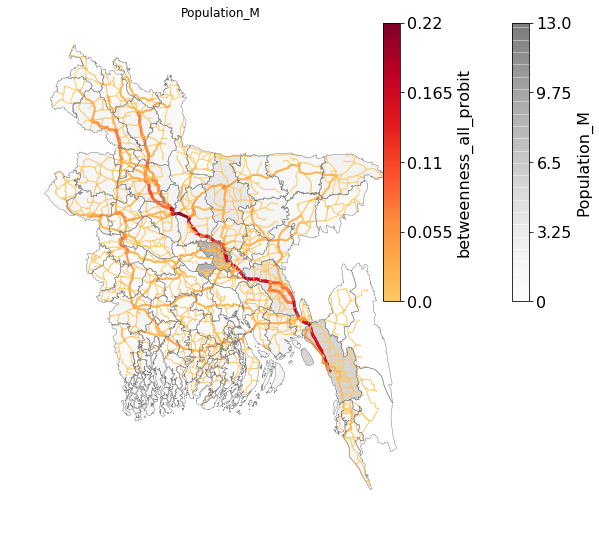

In [53]:
print('Betweenness Criticality of Local Market + Export Market')

net_v.plot_network_admcolmap_betweenness_new(gdf=district_gdf2, gdf2=gdf_final, colname='Population_M',
                                       betweenness_string='betweenness_all_probit', cmap=new_cmap,
                                       maxbetweenness=0.22, maxpop=13, perc1=60, perc2=90)

# plt.savefig('betweenness_all_probit3.png', dpi=400)

In [31]:
import datetime
c = datetime.datetime.now()

#traffic flow assignment
flow_probit_5 = betw_w.probit_assignment(G=G2_new_tograph, sources=centroid_nodes, 
                                              targets=centroid_nodes, weight='length', od=OD_land_export, N=4, penalty=1.2)

betweenness_land_export_probit = betw_w.edge_betweenness_centrality(flow_probit_5, OD_land_export)

gdf_final, betweenness_df = betw_w.betweenness_to_df(gdf_final,betweenness_land_export_probit,'betweenness_land_export_probit')

e = datetime.datetime.now()
print(max(flow_probit_5.values()))
print(max(betweenness_land_export_probit.values()))
print(e-c)

2268615.96192
0.223467023503
0:09:01.473000


Betweenness Criticality of Land Ports based Export Market


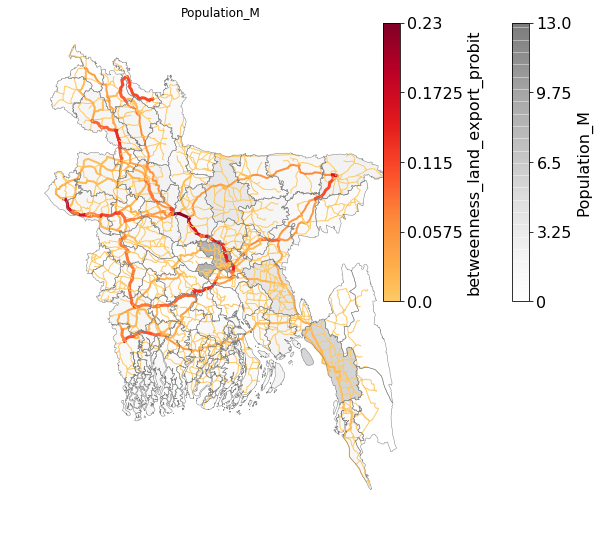

In [54]:
print('Betweenness Criticality of Land Ports based Export Market')

net_v.plot_network_admcolmap_betweenness_new(gdf=district_gdf2, gdf2=gdf_final, colname='Population_M',
                                       betweenness_string='betweenness_land_export_probit', cmap=new_cmap,
                                       maxbetweenness=0.23, maxpop=13, perc1=60, perc2=90)

# plt.savefig('betweenness_land_export_probit3.png', dpi=400)

In [33]:
import datetime
c = datetime.datetime.now()

#traffic flow assignment
flow_probit_5 = betw_w.probit_assignment(G=G2_new_tograph, sources=centroid_nodes, 
                                              targets=centroid_nodes, weight='length', od=OD_local_all, N=4, penalty=1.2)

betweenness_local_probit = betw_w.edge_betweenness_centrality(flow_probit_5, OD_local_all)

gdf_final, betweenness_df = betw_w.betweenness_to_df(gdf_final,betweenness_local_probit,'betweenness_local_probit')

e = datetime.datetime.now()
print(max(flow_probit_5.values()))
print(max(betweenness_local_probit.values()))
print(e-c)

9889711.17932
0.197290285486
0:09:05.745000


Betweenness Criticality of Local Market


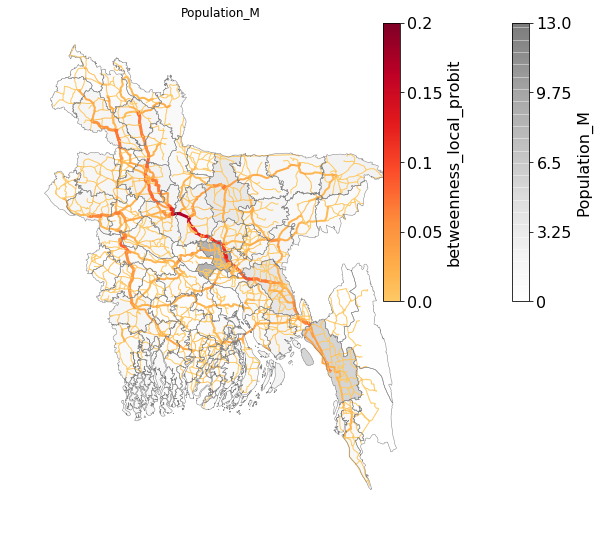

In [52]:
print('Betweenness Criticality of Local Market')

net_v.plot_network_admcolmap_betweenness_new(gdf=district_gdf2, gdf2=gdf_final, colname='Population_M',
                                       betweenness_string='betweenness_local_probit', cmap=new_cmap,
                                       maxbetweenness=0.2, maxpop=13, perc1=60, perc2=90)

# plt.savefig('betweenness_local_probit3.png', dpi=400)

In [35]:
import datetime
c = datetime.datetime.now()

#traffic flow assignment
flow_probit_5 = betw_w.probit_assignment(G=G2_new_tograph, sources=centroid_nodes, 
                                              targets=centroid_nodes, weight='length', od=OD_export, N=4, penalty=1.2)

betweenness_export_probit = betw_w.edge_betweenness_centrality(flow_probit_5, OD_export)

gdf_final, betweenness_df = betw_w.betweenness_to_df(gdf_final,betweenness_export_probit,'betweenness_export_probit')

e = datetime.datetime.now()
print(max(flow_probit_5.values()))
print(max(betweenness_export_probit.values()))
print(e-c)

8235954.22205
0.811273011356
0:09:14.090000


Betweenness Criticality of Export Market


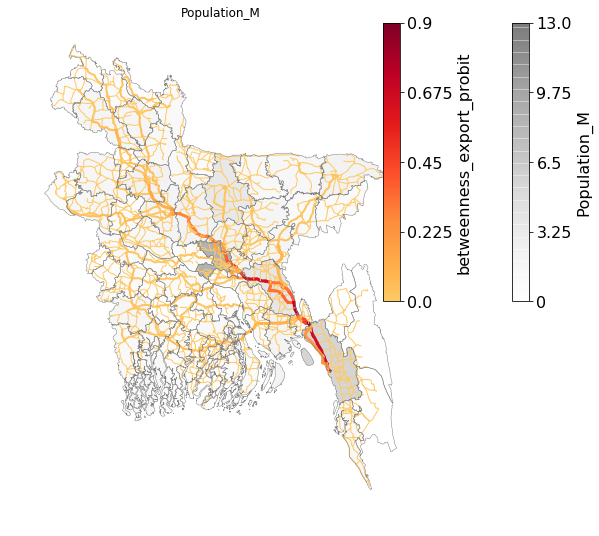

In [57]:
print('Betweenness Criticality of Export Market')

net_v.plot_network_admcolmap_betweenness_new(gdf=district_gdf2, gdf2=gdf_final, colname='Population_M',
                                       betweenness_string='betweenness_export_probit', cmap=new_cmap,
                                       maxbetweenness=0.9, maxpop=13, perc1=60, perc2=90)

# plt.savefig('betweenness_export_probit3.png', dpi=400)

In [37]:
import datetime
c = datetime.datetime.now()

#traffic flow assignment
flow_probit_5 = betw_w.aon_assignment(G=G2_new_tograph, sources=centroid_nodes, 
                                              targets=centroid_nodes, weight='length', od=OD_unweighted)

betweenness_unweighted = betw_w.edge_betweenness_centrality(flow_probit_5, OD_unweighted)

gdf_final, betweenness_df = betw_w.betweenness_to_df(gdf_final,betweenness_unweighted,'betweenness_unweighted')

e = datetime.datetime.now()
print(max(flow_probit_5.values()))
print(max(betweenness_unweighted.values()))
print(e-c)

1036
0.256944444444
0:01:20.487000


Unweighted Betweenness Criticality


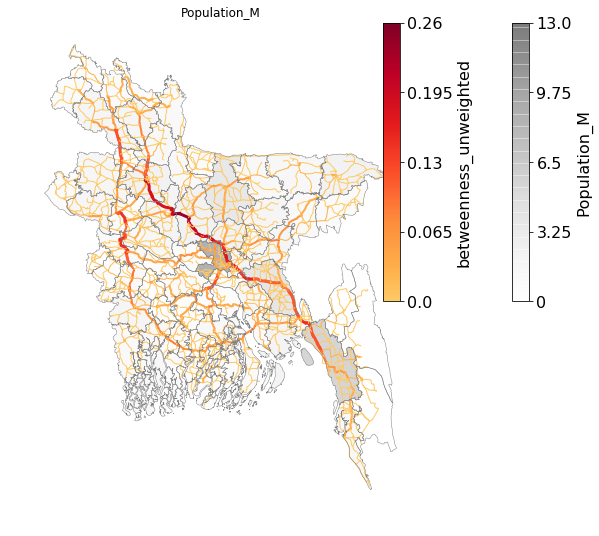

In [58]:
print('Unweighted Betweenness Criticality')

net_v.plot_network_admcolmap_betweenness_new(gdf=district_gdf2, gdf2=gdf_final, colname='Population_M',
                                       betweenness_string='betweenness_unweighted', cmap=new_cmap,
                                       maxbetweenness=0.26, maxpop=13, perc1=60, perc2=90)

# plt.savefig('betweenness_unweighted3.png', dpi=400)

## 5. Minimum edge cut centrality

Save the links cut set for each OD pair. Links cut set are set of links which if simultaneously removed will disconnect a specific OD pair

In [39]:
import datetime
c = datetime.datetime.now()

testcut = []
for i in range(len(centroid_nodes)):
    for j in range(len(centroid_nodes)):
        if i != j:
            testcut2 = nx.minimum_edge_cut(G=G2_new_tograph, s=centroid_nodes[i], t=centroid_nodes[j])
            testcut += testcut2    

e = datetime.datetime.now()
print(e-c)

0:11:36.075000


Create dictionary which stores the occurence of each edge in all cut sets

In [41]:
#save the edge IDs as dictionary key
edgecut_dict = {}
for edge in list(G2_new_tograph.edges()):
    edgecut_dict.update({edge: 0})

In [42]:
#increment the value of the dictionary's key if an edge belongs in a cut set
for i in testcut:
    try:
        edgecut_dict[i] += 1
    except:
        new_tup = tuple([i[1], i[0]])
        edgecut_dict[new_tup] += 1

Save the edge cut set criticality information to the main dataframe

In [46]:
#make a copy, just to be save
gdf_final2 = gdf_final.copy()

#append the edge cut set criticality information
gdf_final2, betweenness_df = betw_w.betweenness_to_df(gdf_final2,edgecut_dict,'Min_EdgeCut_Criticality')

Special visualization code for minimum edge cut set criticality

In [61]:
import matplotlib
def plot_network_admcolmap_betweenness(gdf,gdf2, colname,betweenness_string,
                                       cmap='OrRd', linewidth=1.25, edgecolor='grey',
                                       maxbetweenness=0, maxpop=0):
    fig, ax = plt.subplots(figsize=(12,9))
    
    ax.set_aspect('equal')

    valmin1 = min(list(gdf2[betweenness_string]))
    valmax1 = max(list(gdf2[betweenness_string]))
    gdf2.plot(ax=ax, column=betweenness_string, cmap=cmap,vmin=valmin1, vmax=valmax1, linewidth=linewidth)
    
    #adjust linewidth based on betweenness
    betweenness_list = list(gdf2[betweenness_string])
    #change small betweenness values to 0.1 so that they are still visible in the figure
    betweenness_list = [1 if x < 50 else 2.5 if x >= 50 and x < 200 else 3 for x in betweenness_list]
    i = 0
    for ln in ax.lines:
        ln.set_linewidth(betweenness_list[i]*1)
        ln.set_linewidth(betweenness_list[i])
        i +=1
    
    valmin2 = min(list(gdf[colname]))
    valmax2 = max(list(gdf[colname]))
    gdf.plot(ax=ax, column=colname, cmap='Greys',vmin=valmin2, vmax=valmax2, linewidth=0.5, edgecolor=edgecolor, alpha=0.3)
    
    ax.set_title(colname)
    #remove the lon-lat in the x-y axis of the plot
    ax.axis('off')

    # add colorbar1
    fig = ax.get_figure()
    cax = fig.add_axes([0.85, 0.45, 0.02, 0.43])
    sm = plt.cm.ScalarMappable(cmap='Greys')
    columnlist = list(gdf[colname])
    columnlist.append(0)
    columnlist.append(maxpop) #hardcoded, not good
    cbmin, cbmax = min(columnlist), max(columnlist)
    sm.set_array(columnlist)
    cb = plt.colorbar(sm, cax=cax, label = colname, alpha=0.3)
    labels = [0, cbmax/4, cbmax/4*2, cbmax/4*3, cbmax/4*4]
    loc = labels
    cb.set_ticks(loc)
    cb.set_ticklabels(labels)
    cb.ax.yaxis.label.set_font_properties(matplotlib.font_manager.FontProperties(size=16))
    cb.ax.tick_params(labelsize=16)
    
    #add colorbar2
    fig = ax.get_figure()
    cax = fig.add_axes([0.7, 0.45, 0.02, 0.43])
    sm = plt.cm.ScalarMappable(cmap=cmap)
    columnlist = list(gdf2[betweenness_string])
    columnlist.append(0)
    columnlist.append(maxbetweenness)
    cbmin, cbmax = min(columnlist), max(columnlist)
    cbmin, cbmax = round(cbmin,3), round(cbmax,3)
    sm.set_array(columnlist)
    cb = plt.colorbar(sm, cax=cax, label=betweenness_string)
    labels = [0, cbmax/4, cbmax/4*2, cbmax/4*3, cbmax/4*4]
    loc = labels
    cb.set_ticks(loc)
    cb.set_ticklabels(labels)
    cb.ax.yaxis.label.set_font_properties(matplotlib.font_manager.FontProperties(size=16))
    cb.ax.tick_params(labelsize=16)

import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

OD_all


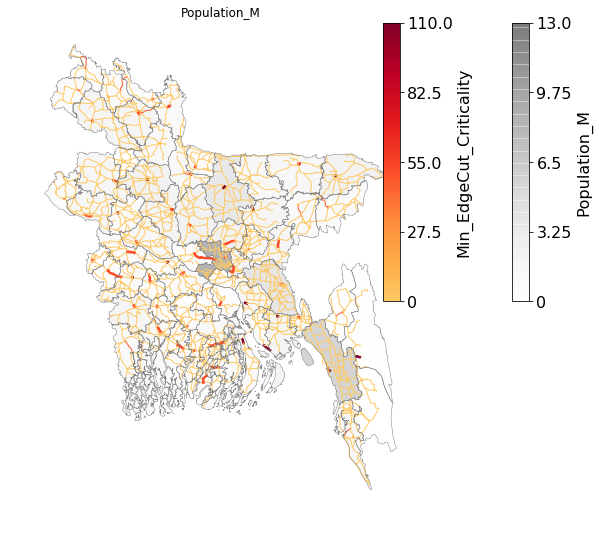

In [62]:
print('OD_all')

plot_network_admcolmap_betweenness(gdf=district_gdf2, gdf2=gdf_final2, colname='Population_M',
                                       betweenness_string='Min_EdgeCut_Criticality', cmap=new_cmap,
                                       maxbetweenness=110, maxpop=13)

plt.savefig('Min_EdgeCut_Criticality3.png', dpi=400)

## 6. Interdiction criticality
Iteratively and independently remove each link one by one, then recalculate the total transport cost (sum of distance traveled * flows magnitude). In this analysis, AON

First record the shortest paths for each OD pair into a dictionary

In [18]:
sp_dict_graph = betw_w.sp_dict_graph_creation(G=G2_new_tograph, sources=centroid_nodes, 
                                              targets=centroid_nodes, weight='length')

Then run the interdiction algorithm

In [19]:
import datetime
timestart = datetime.datetime.now()

new_interdiction_dict, new_disconnected_dict, new_unsatisfied_demand_dict = betw_w.interdiction_single_edge(G2=G2_new_tograph, 
                                                                                                     od=OD_all, weight='length', 
                                                                                                     sp_dict_graph=sp_dict_graph,
                                                                                                     sources=centroid_nodes,
                                                                                                     targets=centroid_nodes)

timeend = datetime.datetime.now()
print(timeend-timestart)

200 edges have been interdicted
400 edges have been interdicted
600 edges have been interdicted
800 edges have been interdicted
1000 edges have been interdicted
1:09:55.091000


Special betweenness to df code for interdiction (will later be integrated with the module's code')

In [24]:
def betweenness_to_df(gdf,betweenness,betweenness_string):
    '''
    Input:
        gdf                : geodataframe of the original network (should contain LineString information)
        betweenness        : dictionary with edge tuple as keys (e.g. (2,3) ) and betweenness value as values
        betweenness_string : string of betweenness dictionary's object name
    Output:
        gdf_final          : updated gdf with additional column of betweenness centrality
        betweenness_df     : betweenness dictionary transformed into dataframe
    '''
    betweenness_df = pd.DataFrame(betweenness.items(), columns=['FromTo', betweenness_string])
    
    c = []
    for i in range(len(gdf)):
        minval = min([gdf['TNODE_'][i],gdf['FNODE_'][i]])
        maxval = max([gdf['TNODE_'][i],gdf['FNODE_'][i]])
        val = str(minval) + str(maxval)
        c.append(val)
    gdf['FromTo'] = c
    
    gdf_final = pd.merge(gdf,betweenness_df,on='FromTo',how='outer')
    
    return gdf_final, betweenness_df

In [25]:
gdf_final, betweenness_df = betweenness_to_df(gdf2,new_interdiction_dict,'Interdiction_Impact')
gdf_final, betweenness_df = betweenness_to_df(gdf_final,new_disconnected_dict,'Disconnected_Pairs')
gdf_final, betweenness_df = betweenness_to_df(gdf_final,new_unsatisfied_demand_dict,'Unsatisfied_Demand(Ton)')

In [43]:
gdf_final = gdf_final.fillna(0)

Special visualization cost for interdiction technique. Later will be integrated with the main module's code.

In [37]:
import matplotlib
def plot_network_admcolmap_betweenness_new(gdf, gdf2, colname,betweenness_string,
                                       cmap='OrRd', linewidth=1.25, edgecolor='grey',
                                       maxbetweenness=0, maxpop=0, thres1=60, thres2=90):
    fig, ax = plt.subplots(figsize=(12,9))

    ax.set_aspect('equal')

    valmin1 = min(list(gdf2[betweenness_string]))
    valmax1 = max(list(gdf2[betweenness_string]))

    gdf2.plot(ax=ax, column=betweenness_string, cmap=cmap,vmin=valmin1, vmax=valmax1, linewidth=linewidth)

    #adjust linewidth based on betweenness
    betweenness_list = list(gdf2[betweenness_string])
    #change the linewidth based on the percentile
    betweenness_list = [1 if x < thres1 else 2 if x >= thres1 and x < thres2 else 3 for x in betweenness_list]
    i = 0
    for ln in ax.lines:
        ln.set_linewidth(betweenness_list[i]*1)
        i +=1

    valmin2 = min(list(gdf[colname]))
    valmax2 = max(list(gdf[colname]))
    gdf.plot(ax=ax, column=colname, cmap='Greys',vmin=valmin2, vmax=valmax2, linewidth=0.5, edgecolor=edgecolor, alpha=0.3)

    ax.set_title(colname)
    #remove the lon-lat in the x-y axis of the plot
    ax.axis('off')

    # add colorbar1
    fig = ax.get_figure()
    cax = fig.add_axes([0.85, 0.45, 0.02, 0.43])
    sm = plt.cm.ScalarMappable(cmap='Greys')
    columnlist = list(gdf[colname])
    columnlist.append(0)
    columnlist.append(maxpop) #hardcoded, not good
    cbmin, cbmax = min(columnlist), max(columnlist)
    sm.set_array(columnlist)
    cb = plt.colorbar(sm, cax=cax, label = colname, alpha=0.3)
    labels = [0, cbmax/4, cbmax/4*2, cbmax/4*3, cbmax/4*4]
    loc = labels
    cb.set_ticks(loc)
    cb.set_ticklabels(labels)
    cb.ax.yaxis.label.set_font_properties(matplotlib.font_manager.FontProperties(size=16))
    cb.ax.tick_params(labelsize=16)

    #add colorbar2
    fig = ax.get_figure()
    cax = fig.add_axes([0.7, 0.45, 0.02, 0.43])
    sm = plt.cm.ScalarMappable(cmap=cmap)
    columnlist = list(gdf2[betweenness_string])
    columnlist.append(maxbetweenness)
    cbmin, cbmax = min(columnlist), max(columnlist)
    sm.set_array(columnlist)
    cb = plt.colorbar(sm, cax=cax, label=betweenness_string)
    poin1 = cbmin+(cbmax-cbmin)/4
    poin2 = cbmin+(cbmax-cbmin)/4*2
    poin3 = cbmin+(cbmax-cbmin)/4*3
    labels = [cbmin, poin1, poin2, poin3, cbmax]
    loc = labels
    cb.set_ticks(loc)
    cb.set_ticklabels(labels)
    cb.ax.yaxis.label.set_font_properties(matplotlib.font_manager.FontProperties(size=16))
    cb.ax.tick_params(labelsize=16)

Interdiction Total Cost


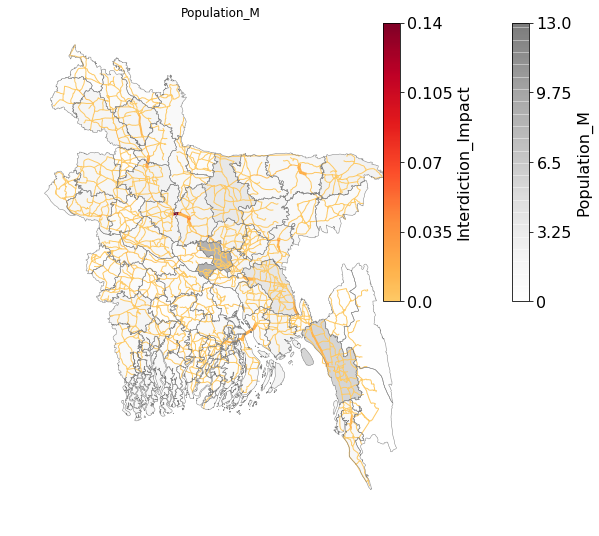

In [45]:
print('Interdiction Total Cost')

plot_network_admcolmap_betweenness_new(gdf=district_gdf2, gdf2=gdf_final, colname='Population_M',
                                       betweenness_string='Interdiction_Impact', cmap=new_cmap,
                                       maxbetweenness=0.14, maxpop=13, thres1=0.01, thres2=0.015)

Unsatisfied Demand (ton)


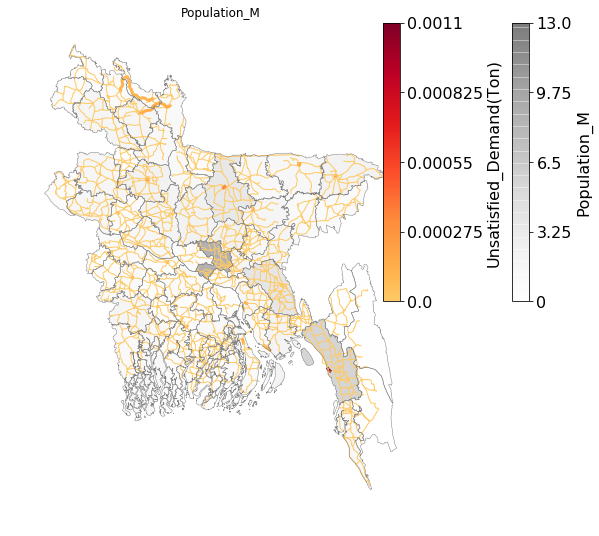

In [49]:
print('Unsatisfied Demand (ton)')
net_v.plot_network_admcolmap_betweenness_new(gdf=district_gdf2, gdf2=gdf_final, colname='Population_M',
                                       betweenness_string='Unsatisfied_Demand(Ton)', cmap=new_cmap,
                                       maxbetweenness=0.0011, maxpop=13, perc1=0.9, perc2=0.95)